In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers


class CustomRNNCell(Layer):
    def __init__(
        self,
        output_dim,
        state_size,
        activation=tf.nn.tanh,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        bias_initializer="zeros",
        initial_state_initializer="zeros",
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        trainable_initial_weights=False,
        **kwargs
    ):
        super(CustomRNNCell, self).__init__(**kwargs)

        self.output_dim = output_dim
        self.state_size = state_size
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.initial_state_initializer = initializers.get(initial_state_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.trainable_initial_weights = trainable_initial_weights

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1] + self.state_size, self.output_dim),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
        )

        self.recurrent_kernel = self.add_weight(
            shape=(input_shape[-1] + self.state_size, self.state_size),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
            regularizer=self.recurrent_regularizer,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.output_dim,),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
            )

            self.recurrent_bias = self.add_weight(
                shape=(self.state_size,),
                initializer=self.bias_initializer,
                name="recurrent_bias",
                regularizer=self.bias_regularizer,
            )

        self.initial_state = self.add_weight(
            shape=(self.state_size,),
            initializer=self.initial_state_initializer,
            name="initial_state",
            trainable=self.trainable_initial_weights,
        )

    def call(self, inputs, states):
        prev_output = states[0]
        if len(prev_output.shape) == 1:
            prev_output = tf.repeat(tf.expand_dims(prev_output, 0), repeats=tf.shape(inputs)[0], axis=0)

        combined_inputs = tf.concat([inputs, prev_output], axis=1)
        h = tf.matmul(combined_inputs, self.kernel)
        if self.use_bias:
            h = tf.nn.bias_add(h, self.bias)

        output = self.activation(h)

        h_recurrent = tf.matmul(combined_inputs, self.recurrent_kernel)
        if self.use_bias:
            h_recurrent = tf.nn.bias_add(h_recurrent, self.recurrent_bias)

        new_state = self.activation(h_recurrent)

        return output, [new_state]

    def get_initial_state(self, batch_size, dtype=None):
        # tile initial state to batch size
        initial_state = tf.tile(tf.expand_dims(self.initial_state, 0), [batch_size, 1])
        return [initial_state]

    def get_config(self):
        config = super(CustomRNNCell, self).get_config()
        config.update(
            {
                "output_dim": self.output_dim,
                "state_size": self.state_size,
                "activation": tf.keras.activations.serialize(self.activation),
                "use_bias": self.use_bias,
                "kernel_initializer": initializers.serialize(self.kernel_initializer),
                "recurrent_initializer": initializers.serialize(self.recurrent_initializer),
                "bias_initializer": initializers.serialize(self.bias_initializer),
                "kernel_regularizer": regularizers.serialize(self.kernel_regularizer),
                "recurrent_regularizer": regularizers.serialize(self.recurrent_regularizer),
                "bias_regularizer": regularizers.serialize(self.bias_regularizer),
                "trainable_initial_weights": self.trainable_initial_weights,
            }
        )
        return config


class CustomRNN(Layer):
    def __init__(self, cell, return_sequences=False, return_state=False, **kwargs):
        super(CustomRNN, self).__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.states = None

    def build(self, input_shape):
        self.cell.build(input_shape)
        self.built = True

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        self.states = self.cell.get_initial_state(batch_size)
        outputs = []
        for t in range(inputs.shape[1]):
            output, self.states = self.cell(inputs[:, t], self.states)
            outputs.append(output)

        if self.return_sequences:
            output = tf.stack(outputs, axis=1)
        else:
            output = outputs[-1]

        if self.return_state:
            return output, self.states
        else:
            return output


In [2]:
import tensorflow as tf
from tensorflow.keras import regularizers
import math

class SparseRegularizer(regularizers.Regularizer):
    def __init__(self, intensity=0.1, threshold=0.1, steepness=100, l1=0.001):
        self.intensity = tf.constant(intensity, dtype=tf.float32)
        self.threshold = tf.constant(threshold, dtype=tf.float32)
        self.steepness = tf.constant(steepness, dtype=tf.float32)
        self.y_shift = tf.math.tanh(-self.threshold * self.steepness)
        self.l1_intensity = tf.constant(l1, dtype=tf.float32)

    def __call__(self, x):
        # abs(x - threshold)
        abs_weights = tf.math.abs(x)
        shifted_weights = abs_weights - self.threshold

        # tanh((x - threshold) * steepness) - tanh(-threshold * steepness)
        tanh_weights = tf.math.tanh(shifted_weights * self.steepness) - self.y_shift

        # Add a bit of l1 regularization. This seems to be important to prevent very large weights.
        l1_weight = tf.reduce_mean(abs_weights) * self.l1_intensity

        # Sum over all elements and scale by intensity
        penalty = tf.reduce_mean(tanh_weights) * self.intensity + l1_weight
        return penalty

    def get_config(self):
        return {'intensity': float(self.intensity), 
                'threshold': float(self.threshold), 
                'steepness': float(self.steepness),
                'l1': float(self.l1_intensity)}


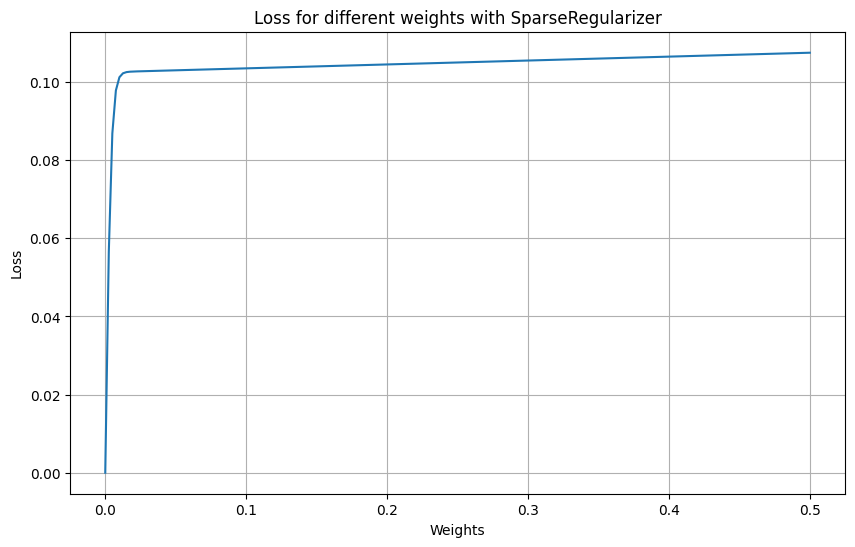

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# initialize the regularizer
reg = SparseRegularizer(intensity=0.1, threshold=0.0001, steepness=250, l1=0.01)

# create an array of weight values
weights = np.linspace(0, 0.5, 200)

# initialize an empty list to store the corresponding loss values
loss_values = []

# compute the loss for each weight
for weight in weights:
    weight_tensor = tf.constant(weight, shape=(1,1), dtype=tf.float32)
    loss = reg(weight_tensor)
    loss_values.append(loss.numpy())

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(weights, loss_values)
plt.xlabel('Weights')
plt.ylabel('Loss')
plt.title('Loss for different weights with SparseRegularizer')
plt.grid(True)
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects


def ameo_grad(x):
    return tf.where(
        (x <= -1.0) & (x > -2.0) | ((x <= 1.0) & (x > 0.0)), 1.0, tf.where((x <= 0.0) & (x > -1.0), -1.0, 0.0)
    )


@tf.custom_gradient
def ameo(x, **kwargs):
    x *= 0.5
    x -= 0.5
    y = tf.where(x <= -1.0, tf.maximum(x + 2.0, 0.0), tf.where(x <= 0.0, -x, tf.minimum(x, 1.0)))
    y = (y - 0.5) * 2.0

    def grad(dy):
        return dy * ameo_grad(x)

    return y, grad


def soft_leaky_ameo_grad(x, leakyness):
    condition1_grad = tf.logical_and(-2 <= x, x <= -1.5)
    condition2_grad = tf.logical_and(-1.5 < x, x <= -0.5)
    condition3_grad = tf.logical_and(-0.5 < x, x <= 0.5)
    condition4_grad = tf.logical_and(0.5 < x, x <= 1)

    grad = tf.where(
        x <= -2,
        leakyness,
        tf.where(
            condition1_grad,
            32 * tf.pow(x + 2, 3),
            tf.where(
                condition2_grad,
                -32 * tf.pow(x, 3) - 96 * tf.pow(x, 2) - 96 * x - 32,
                tf.where(
                    condition3_grad,
                    32 * tf.pow(x, 3),
                    tf.where(condition4_grad, -32 * tf.pow(x, 3) + 96 * tf.pow(x, 2) - 96 * x + 32, leakyness),
                ),
            ),
        ),
    )
    return grad


@tf.custom_gradient
def soft_leaky_ameo(x, leakyness, **kwargs):
    x *= 0.5
    x -= 0.5

    condition1 = tf.logical_and(-2 <= x, x <= -1.5)
    condition2 = tf.logical_and(-1.5 < x, x <= -0.5)
    condition3 = tf.logical_and(-0.5 < x, x <= 0.5)
    condition4 = tf.logical_and(0.5 < x, x <= 1)

    y = tf.where(
        x <= -2,
        leakyness * (x + 2),
        tf.where(
            condition1,
            8 * tf.pow(x + 2, 4),
            tf.where(
                condition2,
                -8 * tf.pow(x, 4) - 32 * tf.pow(x, 3) - 48 * tf.pow(x, 2) - 32 * x - 7,
                tf.where(
                    condition3,
                    8 * tf.pow(x, 4),
                    tf.where(
                        condition4,
                        -8 * tf.pow(x, 4) + 32 * tf.pow(x, 3) - 48 * tf.pow(x, 2) + 32 * x - 7,
                        leakyness * (x - 1) + 1,
                    ),
                ),
            ),
        ),
    )
    y = (y - 0.5) * 2

    def grad(dy):
        return dy * soft_leaky_ameo_grad(x, leakyness), None

    return y, grad


@tf.custom_gradient
def interpolated_ameo(x, factor, leakyness, **kwargs):
    # print(factor)
    # if factor < 0 or factor > 1:
    #     raise ValueError("`factor` must be between 0 and 1")

    y0_mix = factor
    y1_mix = 1 - factor

    y0 = ameo(x) * y0_mix
    y1 = soft_leaky_ameo(x, leakyness) * y1_mix

    y = y0 + y1

    def grad(dy):
        dy0 = ameo_grad(x) * dy * y0_mix
        dy1 = soft_leaky_ameo_grad(x, leakyness) * dy * y1_mix
        return dy0 + dy1, None, None

    return y, grad


class AmeoActivation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AmeoActivation, self).__init__(**kwargs)

    def call(self, inputs):
        return ameo(inputs)

    def get_config(self):
        config = super(AmeoActivation, self).get_config()
        return config


class SoftLeakyAmeoActivation(tf.keras.layers.Layer):
    def __init__(self, leakyness, **kwargs):
        super(SoftLeakyAmeoActivation, self).__init__(**kwargs)
        self.leakyness = leakyness

    def call(self, inputs):
        return soft_leaky_ameo(inputs, self.leakyness)

    def get_config(self):
        config = super(SoftLeakyAmeoActivation, self).get_config()
        config["leakyness"] = self.leakyness
        return config


class InterpolatedAmeoActivation(tf.keras.layers.Layer):
    def __init__(self, factor, leakyness=0.05, **kwargs):
        super(InterpolatedAmeoActivation, self).__init__(**kwargs)
        self.factor = factor
        self.leakyness = float(leakyness)

    def call(self, inputs):
        return interpolated_ameo(inputs, self.factor, self.leakyness)

    def get_config(self):
        config = super(InterpolatedAmeoActivation, self).get_config()
        config["factor"] = self.factor
        config["leakyness"] = self.leakyness
        return config

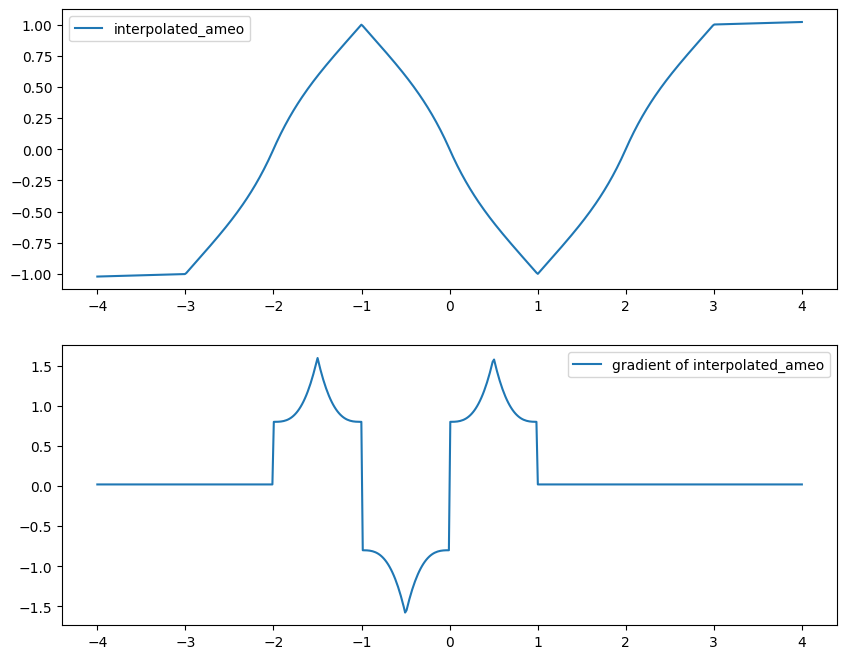

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

x = tf.linspace(-4., 4., num=500)
y = interpolated_ameo(x, 0.8, 0.1)
dy_dx = None

with tf.GradientTape() as g:
    g.watch(x)
    y = interpolated_ameo(x, 0.8, 0.1)
    dy_dx = g.gradient(y, x)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(x, y, label='interpolated_ameo')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, dy_dx, label='gradient of interpolated_ameo')
plt.legend()

plt.show()


In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard

def create_dataset(num_samples=1000, seq_len=10):
    X = np.random.choice([-1, 1], (num_samples, seq_len, 1))
    y = np.pad(X[:, :-1], ((0, 0), (1, 0), (0, 0))) # Shifting the sequence to the right
    y[:, 0, :] = -1 # Set first element to -1 rather than 0
    return X, y

seq_len = 12
reg = SparseRegularizer(intensity = 0.1, threshold=0.025, steepness=30, l1=0.01)
activation = InterpolatedAmeoActivation(0.6, leakyness=1)
input_layer = Input(shape=(seq_len, 1))
rnn_cell = CustomRNNCell(output_dim=4, state_size=2, activation=activation, trainable_initial_weights=True, kernel_regularizer=reg, recurrent_regularizer=reg)
rnn_layer = CustomRNN(rnn_cell, return_sequences=True)(input_layer)
dense_layer = Dense(1, kernel_regularizer=reg, activation='linear')(rnn_layer)
model = Model(inputs=input_layer, outputs=dense_layer)

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01))

# Training loop
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    X_train, y_train = create_dataset(2000, seq_len)
    model.fit(X_train, y_train, epochs=1, batch_size=128, verbose=1, callbacks=[])

# Print the weights, biases, and learned initial states
np.set_printoptions(suppress=True)
for layer in model.layers:
    if isinstance(layer, CustomRNN):
        print("Weights:")
        print(layer.cell.kernel.numpy())
        print("Recurrent Weights:")
        print(layer.cell.recurrent_kernel.numpy())
        if layer.cell.use_bias:
            print("Bias:")
            print(layer.cell.bias.numpy())
            print("Recurrent Bias:")
            print(layer.cell.recurrent_bias.numpy())
        if layer.cell.trainable_initial_weights:
            print("Initial state:")
            print(layer.cell.initial_state.numpy())


Epoch 1/100
16/16 [==============================] - 13s 9ms/step - loss: 1.5377
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 1.6911
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 1.7323
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 1.5430
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 1.3159
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 1.5086
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 1.4373
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 1.2584
Epoch 9/100
16/16 [==============================] - 0s 12ms/step - loss: 1.1452
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: 1.0531
Epoch 11/100
16/16 [==============================] - 0s 12ms/step - loss: 0.9907
Epoch 12/100
16/16 [==============================] - 0s 11ms/step - loss: 0.9501
Epoch 13/100
16/16 [=========

In [8]:
# Generate a sequence
X_test, y_test = create_dataset(num_samples=1, seq_len=seq_len)

# Predict the output sequence
y_pred = model.predict(X_test)

# Print the input and output sequences
print("Input sequence:")
print(X_test[0])
print("True output sequence:")
print(y_test[0])
print("Predicted output sequence:")
print(y_pred[0])


1/1 [==============================] - 4s 4s/step
Input sequence:
[[-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]]
True output sequence:
[[-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]]
Predicted output sequence:
[[-0.99060667]
 [-1.0256392 ]
 [ 1.0000315 ]
 [ 0.9984298 ]
 [ 0.9979434 ]
 [-1.020042  ]
 [-0.9979085 ]
 [-0.99794763]
 [-1.0027272 ]
 [ 1.0000412 ]
 [ 0.9984294 ]
 [ 0.9984288 ]]
